NOTE:<br>
THE CODE NEEDED TO BE MODIFIED FOR THIS TO WORK:<br>
in bbSearch.py<br>
comment out the line:<br>
`global weight_function`<br>
This doesn't change the functionality and makes it possible to solve 2 search problems at onces

# Core problem, test suite, procedural level generation and heuristic

In [8]:
#!mkdir -p bbmodcache
#!curl http://bb-ai.net.s3.amazonaws.com/bb-python-modules/bbSearch.py > bbmodcache/bbSearch.py
from bbmodcache.bbSearch import SearchProblem, search
from random import randint, seed
from copy import deepcopy
import pandas as pd
from bisect import insort

from itertools import combinations
from random import shuffle, random
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import numpy as np
import os
import glob

import multiprocessing

from scipy.optimize import minimize
from numpy import loadtxt, savetxt

seed(123)

class Robot:
    def __init__(self, location, carried_items, strength):
        self.location      = location
        self.carried_items = carried_items
        self.strength      = strength
        
    def weight_carried(self):
        return sum([ITEM_WEIGHTS[i] for i in self.carried_items])
                
class Door:
    def __init__(self, roomA, roomB, doorkey=None, locked=False):
        self.goes_between = {roomA, roomB}
        self.doorkey      = doorkey
        self.locked       = locked
        # Define handy dictionary to get room on other side of a door
        self.other_loc = {roomA:roomB, roomB:roomA}
    
    def __eq__(self, other):
        return self.goes_between == other.goes_between
    
class State:
    def __init__( self, robot, doors, room_contents ):
        self.robot = robot
        self.doors = doors
        self.room_contents = room_contents
        
    ## Define a string representation that will be uniquely identify the state.
    ## An easy way is to form a tuple of representations of the components of 
    ## the state, then form a string from that:
    def __repr__(self):
        return str( ( self.robot.location, self.robot.carried_items,
                      [d.locked for d in self.doors],
                      self.room_contents ) )   

class RobotServant( SearchProblem ):
    
    def __init__(self, state:State, goal_item_locations, item_weights):
        self.initial_state = state
        self.goal_item_locations = goal_item_locations
        self.item_weights = item_weights
        
    def possible_actions( self, state ):
        
        robot_location = state.robot.location
        strength       = state.robot.strength
        weight_carried = state.robot.weight_carried()
        
        actions = []
        # Can put down any carried item
        for i in state.robot.carried_items:
            actions.append(("put down", i))

        # Can pick up any item in room if strong enough    
        for i in state.room_contents[robot_location]:
            if strength >= weight_carried + ITEM_WEIGHTS[i]:
                actions.append(("pick up", i))
                
        # If there is an unlocked door between robot location and
        # another location can move to that location
        for door in state.doors:
            if robot_location in door.goes_between:
                if door.locked:
                    if door.doorkey in state.robot.carried_items:
                        actions.append(("unlock", door))
                else:
                    actions.append(("move to", door.other_loc[robot_location]))
                
        # Now the actions list should contain all possible actions
        return actions
    
    def successor( self, state, action):
        next_state = deepcopy(state)
        act, target = action
        if act== "put down":
            next_state.robot.carried_items.remove(target)
            insort(next_state.room_contents[state.robot.location], target)
            
        if act == "pick up":
            insort(next_state.robot.carried_items, target)
            next_state.room_contents[state.robot.location].remove(target)
            
        if act == "move to":
            next_state.robot.location = target
            
        if act == "unlock":
            next_state.doors[next_state.doors.index(target)].locked = False
            
        return next_state
        
    def goal_test(self, state):
        # ensure the global item weights and goal locations are up-to-date (this func is called first)
        global GOAL_ITEM_LOCATIONS
        global ITEM_WEIGHTS
        GOAL_ITEM_LOCATIONS = self.goal_item_locations
        ITEM_WEIGHTS = self.item_weights
        
        for room, contents in GOAL_ITEM_LOCATIONS.items():
            if contents == None:
                continue
                
            for i in contents:
                if not i in state.room_contents[room]:
                    return False
        return True
    
    def display_state(self,state):
        print("Robot location:", state.robot.location)
        print("Robot carrying:", state.robot.carried_items)
        print("Room contents:", state.room_contents)


def cost(p, s):
    return len(p)


# TEST SUITE
def test_algorithm(test_states, mode='BF', max_nodes=100000, loop_check=False, randomise=False, cost=None, heuristic=None):
    time = 0
    memory = 0
    solution_efficiency = 0
    err_counter = 0
    success_counter = 0
    
    for state in test_states:
        result = search(problem=state, mode=mode,
                        max_nodes=max_nodes, loop_check=loop_check, randomise=randomise, cost=cost, heuristic=heuristic,
                        show_path=False, show_state_path=False, dots=False, return_info=True, print_debug=False)
        
        time += result['search_stats']['time_taken']
        memory += result['search_stats']['nodes_generated']
        if result['result']['termination_condition'] == 'GOAL_STATE_FOUND':
            solution_efficiency += result['result']['path_length']
            success_counter += 1
        else:
            err_counter += 1
            
            # allow for max 5% error rate
            if err_counter / len(test_states) >= 0.05:
                break
    
    count = err_counter + success_counter
    print('.', end='')
    return {
        'mode': mode,
        'loop_check': str(loop_check),
        'randomise': str(randomise),
        'cost_used': 'Yes' if cost is not None else 'No',
        'heuristic_used': heuristic.__name__ if heuristic is not None else 'None',
        'time': time / count,
        'memory': memory / count,
        'solution_efficiency': (solution_efficiency / count) if success_counter >= 0.5 * len(test_states) else 'ERROR',
        'successful_runs': success_counter,
        'failed_runs': err_counter
    }


def full_test(states, max_nodes, modes=('BF', 'DF'),
              loop_checks=(False, True), randomises=(False, True), costfs=(None, cost),
              heuristicfs=[None]):
    df = pd.DataFrame()

    for mode in modes:
        for loop_check in loop_checks:
            for randomise in randomises:
                for costf in costfs:
                    for heuristicf in heuristicfs:
                        df = df.append(test_algorithm(states, mode=mode, max_nodes=max_nodes,
                                                      loop_check=loop_check, randomise=randomise,
                                                      cost=costf, heuristic=heuristicf),
                                       ignore_index=True)

    df=df.set_index(['mode', 'loop_check', 'randomise', 'cost_used', 'heuristic_used'])
    return df



# TEST GENERATION

seed(123)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

class PlaceKeyProblem(SearchProblem):
    def __init__(self, state:str, goal:str, doors:list[Door]):
        self.initial_state = state
        self.goal = goal
        self.doors = doors
        
    def possible_actions(self, state):
        actions = list()
        
        for door in self.doors:
            # new version: don't care about locked doors
            if state in door.goes_between:
                actions.append(("move", door.other_loc[state]))
        
        return actions

    def successor(self, state, action):
        act, next_state = action
        return next_state

    def goal_test(self, state):        
        return state == self.goal

    def display_state(self,state):
        pass
        
    
def all_doors(rooms_count):
    return [Door('Room ' + str(x[0]), 'Room ' + str(x[1])) for x in combinations(range(rooms_count), 2)]


def find_doors_for_room(room, doors, ignored_doors=list()):
    return [x for x in doors if room in x.goes_between and x not in ignored_doors]


def traverse_random(start_room, doors, n, doors_not_to_use):
    result = start_room
    locked_doors_bypassed = list()
    for _ in range(n):
        # store this to make this function faster
        choices = find_doors_for_room(result, doors, doors_not_to_use)
        if len(choices) > 0:
            choice = choices[randint(0, len(choices) - 1)]
            if choice.locked:
                doors_not_to_use.append(choice)
                locked_doors_bypassed.append(choice)
            result = choice.other_loc[result]
        else:
            return result, locked_doors_bypassed
        
    return result, locked_doors_bypassed


# recursively places keys (at least 1) so that all the rooms locked by these keys can be accessed
# modifies keys_already_placed on the go
def place(key, door, start_room, doors, n, room_contents, keys_already_placed=list(), doors_not_to_use=list()):
    if len(doors_not_to_use) == 0:
        doors_not_to_use = [door]
    
    room, bypassed_doors = traverse_random(start_room, doors, n, doors_not_to_use)
    
    if room not in room_contents:
        room_contents[room] = list()
    room_contents[room].append(key)
    keys_already_placed.append(key)
    
    for bypassed_door in bypassed_doors[::-1]:
        doors_not_to_use.append(bypassed_door)
        
        if bypassed_door.doorkey in keys_already_placed:
            continue
        
        place(bypassed_door.doorkey, bypassed_door, start_room, doors, n, room_contents, keys_already_placed, doors_not_to_use)
        
    
def generate(robot_capacity, rooms_count, additional_doors_count, locked_doors_count,
             goal_items_count, useless_items_count, max_item_weight, visualise=False, save=True, file_name='level.png'):

    robot = Robot('Room 0', [], robot_capacity)

    room_contents = dict()
    item_weights = dict()
    goal_item_locations = dict()

    # create empty rooms
    for i in range(rooms_count):
        room_contents['Room ' + str(i)] = list()

    # add useless items to rooms
    for i in range(useless_items_count):
        item = 'Useless item ' + str(i)
        item_weights[item] = randint(0, max_item_weight)
        insort(room_contents['Room ' + str(randint(0, rooms_count - 1))], item)
    
    # we want to have twice as many light items as we do hard for more uniform levels
    light_items_weights = [randint(1, max_item_weight // 2) for _ in range(goal_items_count * 2)]
    heavy_items_weights = [randint(max_item_weight // 2 + 1, max_item_weight) for _ in range(goal_items_count)]
    weights = light_items_weights + heavy_items_weights
    shuffle(weights)
    
    # add goal items to rooms
    for i in range(goal_items_count):
        item = 'Goal item ' + str(i) 
        item_weights[item] = weights[i]
        insort(room_contents['Room ' + str(randint(0, rooms_count - 1))], item)
        
        randgoal = 'Room ' + str(randint(0, rooms_count - 1))
        if randgoal not in goal_item_locations or goal_item_locations[randgoal] is None:
            goal_item_locations[randgoal] = list()
        insort(goal_item_locations[randgoal], item)
    
    # create doors
    doors = [Door('Room 1', 'Room 0')]
    for i in range(2, rooms_count):
        doors.append(Door('Room ' + str(i), 'Room ' + str(randint(0, i - 1))))

    additional_doors = [x for x in all_doors(rooms_count) if x not in doors]
    shuffle(additional_doors)
    doors += additional_doors[:min(len(additional_doors), additional_doors_count)]

    # lock the desired number of doors and create appropriate keys
    shuffle(doors)
    keys = dict()
    for i in range(min(len(doors), locked_doors_count)):
        doorkey = 'Key ' + str(i)
        doors[i].locked = True
        doors[i].doorkey = doorkey
        item_weights[doorkey] = 0
        keys[doorkey] = doors[i]

    # place all keys in rooms randomly but the puzzle will still remain solvable
    not_placed = list(keys.keys())
    placed = list()
    while len(not_placed) > 0:
        place(not_placed[0], keys[not_placed[0]], 'Room 0', doors, 20, room_contents, placed)
        not_placed = [x for x in not_placed if x not in placed]
    
    # matplotlib level preview
    text = list()
    roomsx = [i % round(rooms_count**0.5) + (random() - 0.5) * 0.5 for i in range(rooms_count)]
    roomsy = [i // round(rooms_count**0.5) + (random() - 0.5) * 0.5 for i in range(rooms_count)]

    fig, ax = plt.subplots()
    ax.scatter(roomsx, roomsy, s=1000, c='teal')
    for room in room_contents:
        room_i = int(room.replace('Room ', ''))
        text.append(ax.text(roomsx[room_i], roomsy[room_i] - 0.1, s = room_i, c='teal'))

    for door in doors:
        for e in door.goes_between:
            break
        room0, room1 = e, door.other_loc[e]
        room0 = room0.replace('Room ', '')
        room1 = room1.replace('Room ', '')
        ax.plot((roomsx[int(room0)], roomsx[int(room1)]),
                (roomsy[int(room0)], roomsy[int(room1)]), c='lightgreen' if not door.locked else 'red')


    for room, contents in room_contents.items():
        room_i = int(room.replace('Room ', ''))

        # first plot useless cause they don't matter
        for item in contents:
            if 'Useless' in item:
                x = roomsx[room_i] + (random() - 0.5) * 0.3
                y = roomsy[room_i] + (random() - 0.5) * 0.3
                ax.scatter(x, y, c='grey', s = 100)

        # the plot goal
        for item in contents:
            if 'Goal' in item:
                for goal, goal_content in goal_item_locations.items():
                    if item in goal_content:
                        x = roomsx[room_i] + (random() - 0.5) * 0.3
                        y = roomsy[room_i] + (random() - 0.5) * 0.3
                        ax.scatter(x, y, c='yellowgreen', s = 150)
                        text.append(ax.text(x, y, s=goal.replace('Room ', ''), c='yellowgreen',
                                           ha='center', va='center'))
                        break

        # then keys that should always be visible
        for item in contents:
            if 'Key' in item:
                door = [x for x in doors if x.doorkey == item][0]
                for e in door.goes_between:
                    break
                room0, room1 = e, door.other_loc[e]
                x = roomsx[room_i] + (random() - 0.5) * 0.3
                y = roomsy[room_i] + (random() - 0.5) * 0.3
                ax.scatter(x, y, c='gold', s = 200)
                text.append(ax.text(x, y, s=room0.replace('Room ', '') + '-' + room1.replace('Room ', ''),
                                    c='gold', ha='center', va='center'))
#                 text.append(ax.text(x, y + 0.2, s=item,
#                                     c='black', ha='center', va='center'))


    for t in text:
        t.set_path_effects([path_effects.Stroke(linewidth=0.5, foreground='black'),
                       path_effects.Normal()])
    
    if save:
        plt.savefig(f'levels/{file_name}')
    
    if visualise:
        plt.show()
    plt.close()
    return RobotServant(State(robot, doors, room_contents), goal_item_locations, item_weights)





# HEURISTIC
class DistanceProblem(SearchProblem):
    
    def __init__(self, state:str, goal:str, doors:list[Door], respect_locked=False):
        self.initial_state = state
        self.goal = goal
        self.doors = doors
        self.respect_locked = respect_locked
        self.keys_acquiring_cost = 0
        
    def possible_actions(self, state):
        actions = list()
        
        for door in self.doors:
            if state in door.goes_between:
                # TODO: maybee if requires key, first find out the cost of getting the key and sum up these 2
                # watch out for infinite recursion...
                if self.respect_locked and door.locked:
#                     result = search(DistanceProblem(state.robot.location, room, state.doors),
#                                                     "BF",
#                                                     1000,
#                                                     loop_check=True,
#                                                     randomise=False,
#                                                     cost=None,
#                                                     heuristic=None,
#                                                     show_path=False,
#                                                     show_state_path=False,
#                                                     dots=False,
#                                                     return_info=True,
#                                                     print_debug=False)

#                 if result['result']['termination_condition'] != 'GOAL_STATE_FOUND':
#                     pass # what to do if couldn't find the path?
#                 else:
#                     self.keys_acquiring_cost += result['result']['path_length']
                    pass
                        
                else:
                    actions.append(("move", door.other_loc[state]))
                
        return actions

    def successor(self, state, action):
        act, next_state = action
        return next_state

    def goal_test(self, state):
        if state == self.initial_state:
            self.keys_acquiring_cost = 0
        return state == self.goal

    def display_state(self,state):
        pass

# cumulative distance of all the items from their goal rooms (useless items are skipped)
def distance_items(state):
    res = 0
    for goal_room, goal_items in GOAL_ITEM_LOCATIONS.items():
        for item in goal_items:
            # find the room that the item is currently in
            if item in state.robot.carried_items:
                current_room = state.robot.location
            else:
                for r, i in state.room_contents.items():
                    if item in i:
                        current_room = r
                        break
            
            # perform bf search for the path length 
            result = search(DistanceProblem(current_room, goal_room, state.doors),
                            "BF",
                            1000,
                            loop_check=True,
                            randomise=False,
                            cost=None,
                            heuristic=None,
                            show_path=False,
                            show_state_path=False,
                            dots=False,
                            return_info=True,
                            print_debug=False)
            
            # if there's no path, the puzzle is impossible
            if result['result']['termination_condition'] != 'GOAL_STATE_FOUND':
                print("IMPOSSIBLE PUZZLE!!!!! OR TOO COMPLICATED ROOM LAYOUT")
                res += 99999999999
            else:
                res += result['result']['path_length']
            # print(item, 'FROM', current_room, 'TO', goal_room, 'PATH LENGTH:', result['result']['path_length'])
    
    return res


def distance_robot(state):
    res = 0
    
    # for all the items in rooms (no need to compute for carried items as it's always 0)
    for room, items in state.room_contents.items():
        # check if item is a goal item
        # TODO: performance improvement if we store goal items in an array
        #       and useless items in another one
        #       these two arrays can be altered using the below code so no big changes necessary
        #       if decided to do that though, remember to alter the code in the heuristic as well
        for item in items:
            is_goal = False
            for goal_room, goal_items in GOAL_ITEM_LOCATIONS.items():
                # only consider goal items that are not in the goal room yet
                if item in goal_items and room != goal_room:
                    is_goal = True
                    break

            if not is_goal:
                continue
                
            result = search(DistanceProblem(state.robot.location, room, state.doors),
                            "BF",
                            1000,
                            loop_check=True,
                            randomise=False,
                            cost=None,
                            heuristic=None,
                            show_path=False,
                            show_state_path=False,
                            dots=False,
                            return_info=True,
                            print_debug=False)

            # if there's no path, the puzzle is impossible
            if result['result']['termination_condition'] != 'GOAL_STATE_FOUND':
                print("IMPOSSIBLE PUZZLE!!!!! OR TOO COMPLICATED ROOM LAYOUT")
                res += 99999999999
            else:
                res += result['result']['path_length']
            # print(item, 'FROM ROBOT', state.robot.location, 'TO', room, 'PATH LENGTH:', result['result']['path_length'])
                
    return res
    

def heuristic_optimized(state):
    global w
    
    # big cumulative distance from items to their goal locations is bad
    itmdist = distance_items(state)
    
    # robot far to incorrectly placed goal items is bad
    robdist = distance_robot(state)
        
    # carried, 'useless' items are bad
    carried_useless = 0
    for item in state.robot.carried_items:
        useful = False
        for goal_room, goal_items in GOAL_ITEM_LOCATIONS.items():
            if item in goal_items:
                useful = True
                break
        if not useful:
            carried_useless += 1
    
    # carried keys for unlocked doors are bad if they weigh anything
    incorrect_keys = 0
    for door in state.doors:
        if not door.locked and door.doorkey in state.robot.carried_items and ITEM_WEIGHTS[door.doorkey] > 0:
            incorrect_keys += 1
    
    # locked doors are bad
    locked_doors = sum([1 if door.locked else 0 for door in state.doors])
    
    # carried items in incorrect rooms are good
    carried_incorrect = 0
    for item in state.robot.carried_items:
        for goal_room, goal_items in GOAL_ITEM_LOCATIONS.items():
            if item in goal_items and state.robot.location != goal_room:
                carried_incorrect += 1
    
    # not-carried items in correct rooms are good
    not_carried_correct = 0
    for current_room, current_items in state.room_contents.items():
        for item in current_items:
            if current_room in GOAL_ITEM_LOCATIONS and item in GOAL_ITEM_LOCATIONS[current_room]:
                not_carried_correct += 1
    
    # carried keys for locked doors are good
    correct_keys = 0
    for door in state.doors:
        if door.locked and door.doorkey in state.robot.carried_items:
            correct_keys += 1
    
    return np.dot(np.array([robdist,
                            itmdist,
                            incorrect_keys,
                            carried_useless,
                            locked_doors,
                            carried_incorrect,
                            not_carried_correct,
                            correct_keys]), np.transpose(w))

# Tests generation

TODO: save and load levels from files (not only previews)

In [9]:
files = glob.glob('levels/easy*.png')
for f in files:
    os.remove(f)
    
easy = [generate(robot_capacity=25,
                 rooms_count=4,
                 additional_doors_count=0,
                 locked_doors_count=1,
                 goal_items_count=5,
                 useless_items_count=10,
                 max_item_weight=12,
                 visualise=False,
                 save=True,
                 file_name=f'easy_{x}.png') for x in range(20)]

In [10]:
full_test(easy, 200000, modes=['BF'], loop_checks=[True], randomises=[False], costfs=[None], heuristicfs=[heuristic_optimized])

.

time  memory  \
mode loop_check randomise cost_used heuristic_used                          
BF   True       False     No        heuristic_optimized  0.041616  166.05   

                                                         solution_efficiency  \
mode loop_check randomise cost_used heuristic_used                             
BF   True       False     No        heuristic_optimized                17.15   

                                                         successful_runs  \
mode loop_check randomise cost_used heuristic_used                         
BF   True       False     No        heuristic_optimized             20.0   

                                                         failed_runs  
mode loop_check randomise cost_used heuristic_used                    
BF   True       False     No        heuristic_optimized          0.0

In [3]:
files = glob.glob('levels/medium*.png')
for f in files:
    os.remove(f)
    
medium = [generate(robot_capacity=25,
                 rooms_count=5,
                 additional_doors_count=2,
                 locked_doors_count=5,
                 goal_items_count=5,
                 useless_items_count=10,
                 max_item_weight=12,
                 visualise=False,
                 save=True,
                 file_name=f'medium_{x}.png') for x in range(20)]

In [4]:
files = glob.glob('levels/hard*.png')
for f in files:
    os.remove(f)

hard = [generate(robot_capacity=25,
                 rooms_count=8,
                 additional_doors_count=2,
                 locked_doors_count=9,
                 goal_items_count=5,
                 useless_items_count=10,
                 max_item_weight=12,
                 visualise=False,
                 save=True,
                 file_name=f'hard_{x}.png') for x in range(20)]

In [5]:
files = glob.glob('levels/insane*.png')
for f in files:
    os.remove(f)

insane = [generate(robot_capacity=25,
                 rooms_count=12,
                 additional_doors_count=3,
                 locked_doors_count=12,
                 goal_items_count=8,
                 useless_items_count=12,
                 max_item_weight=12,
                 visualise=False,
                 save=True,
                 file_name=f'insane_{x}.png') for x in range(20)]

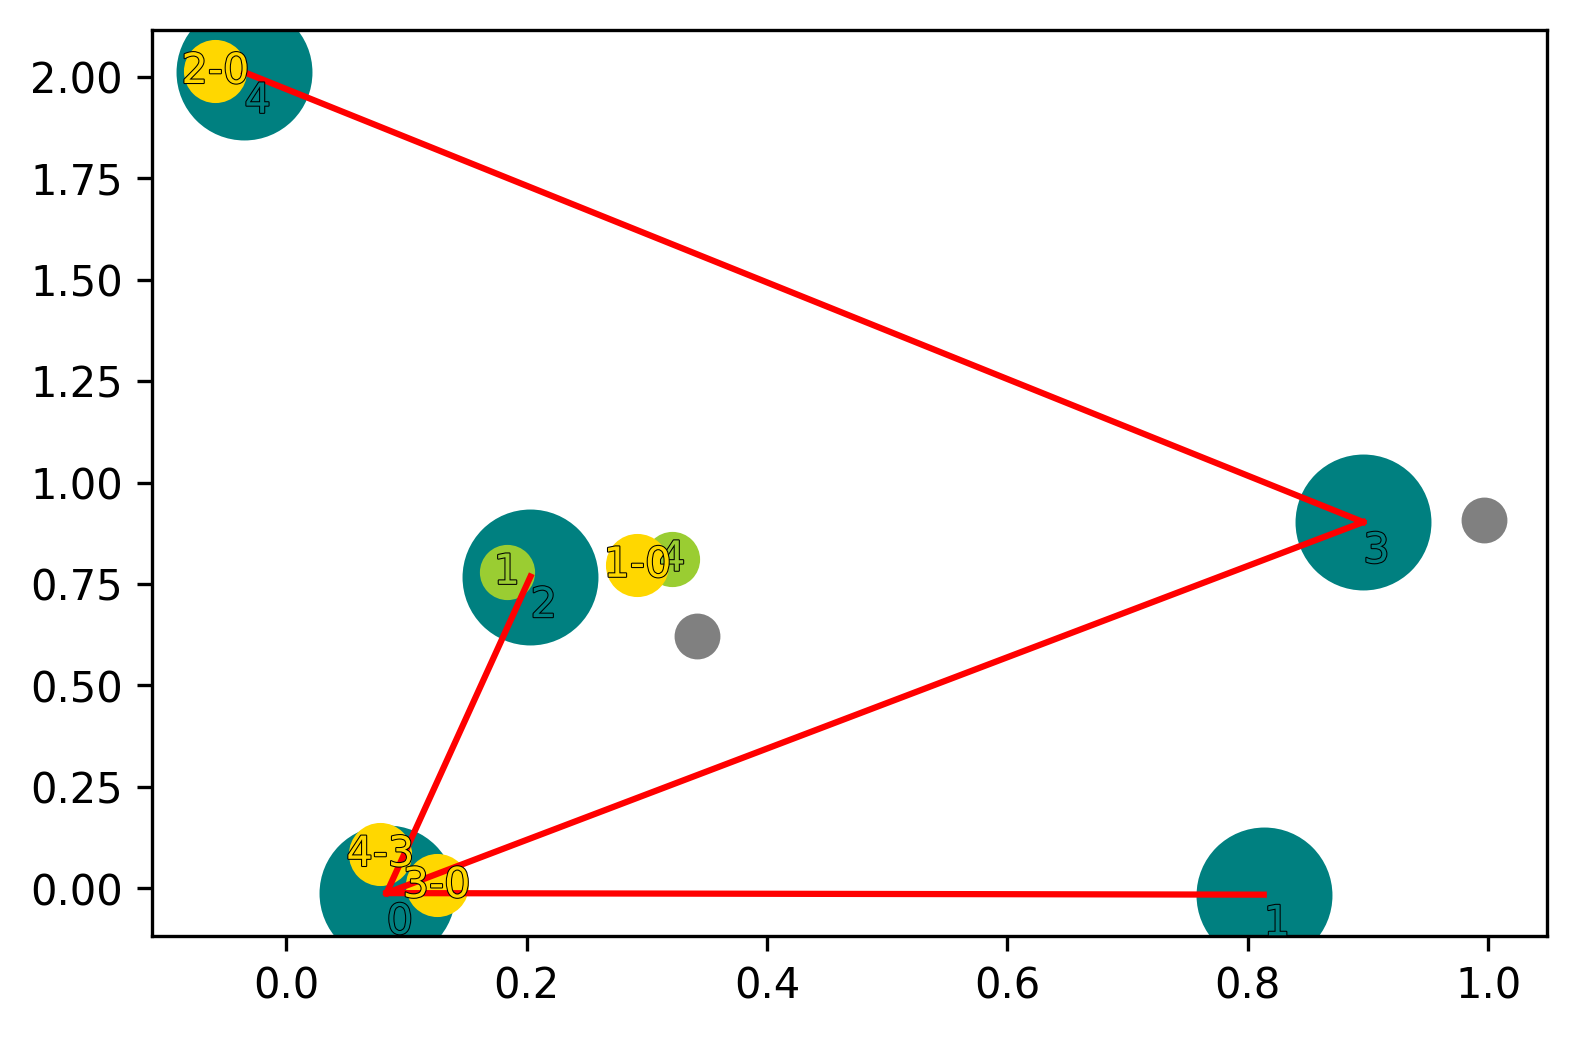

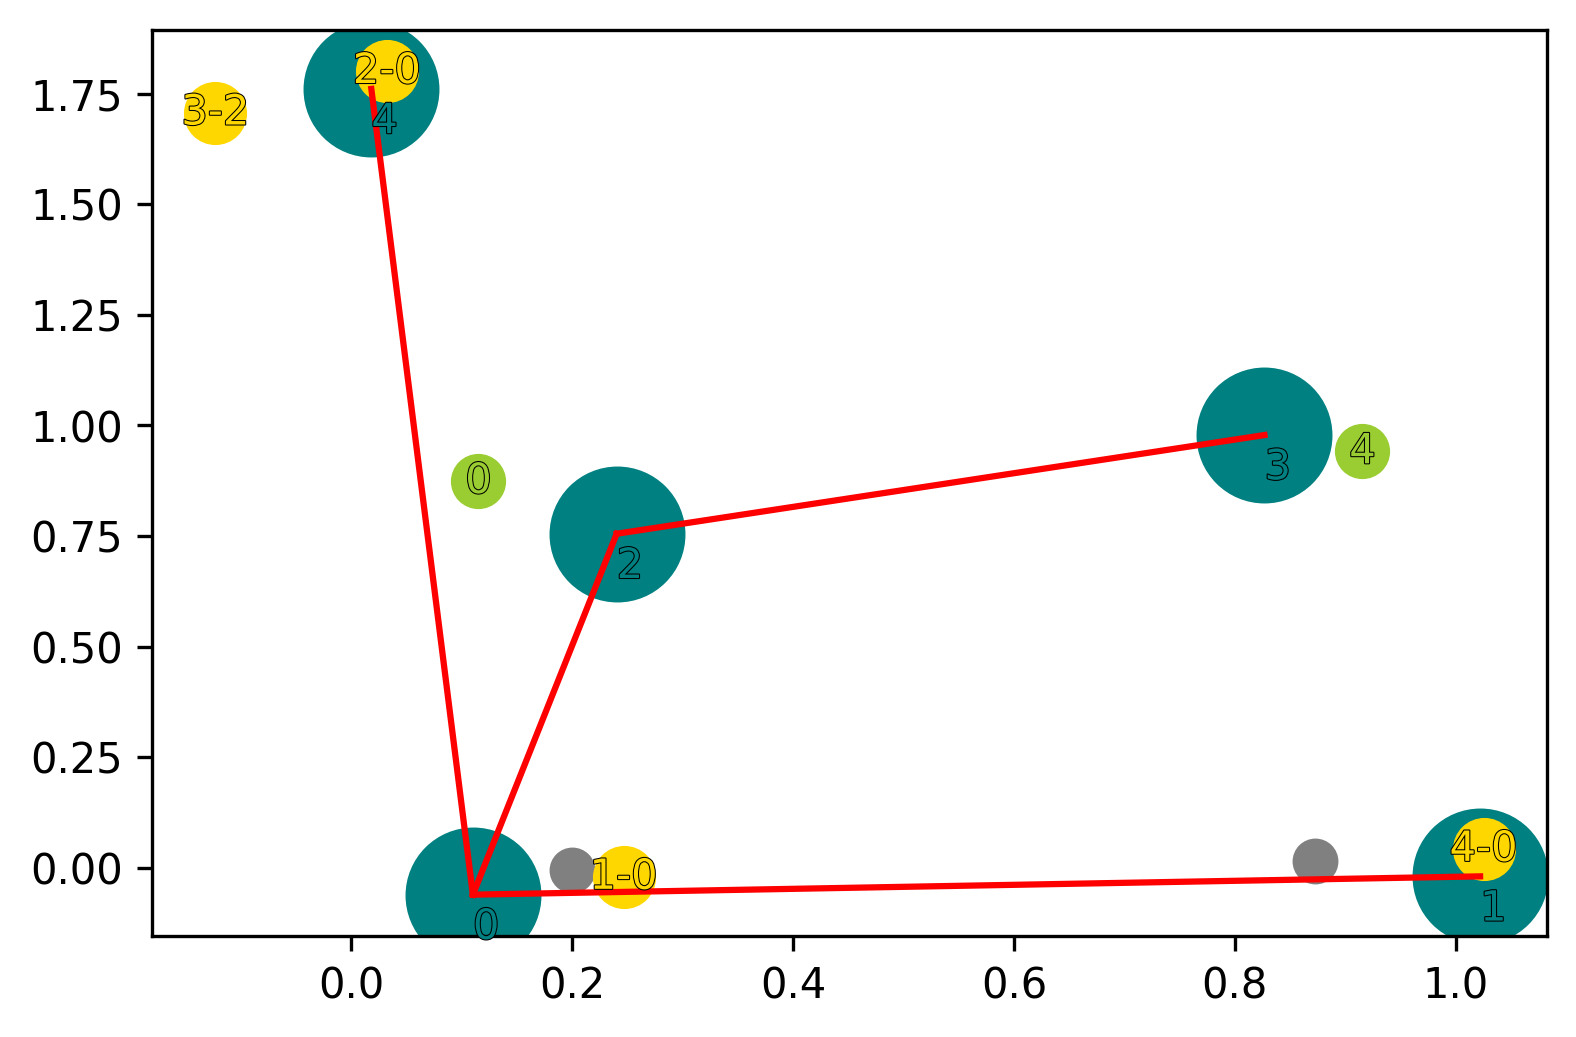

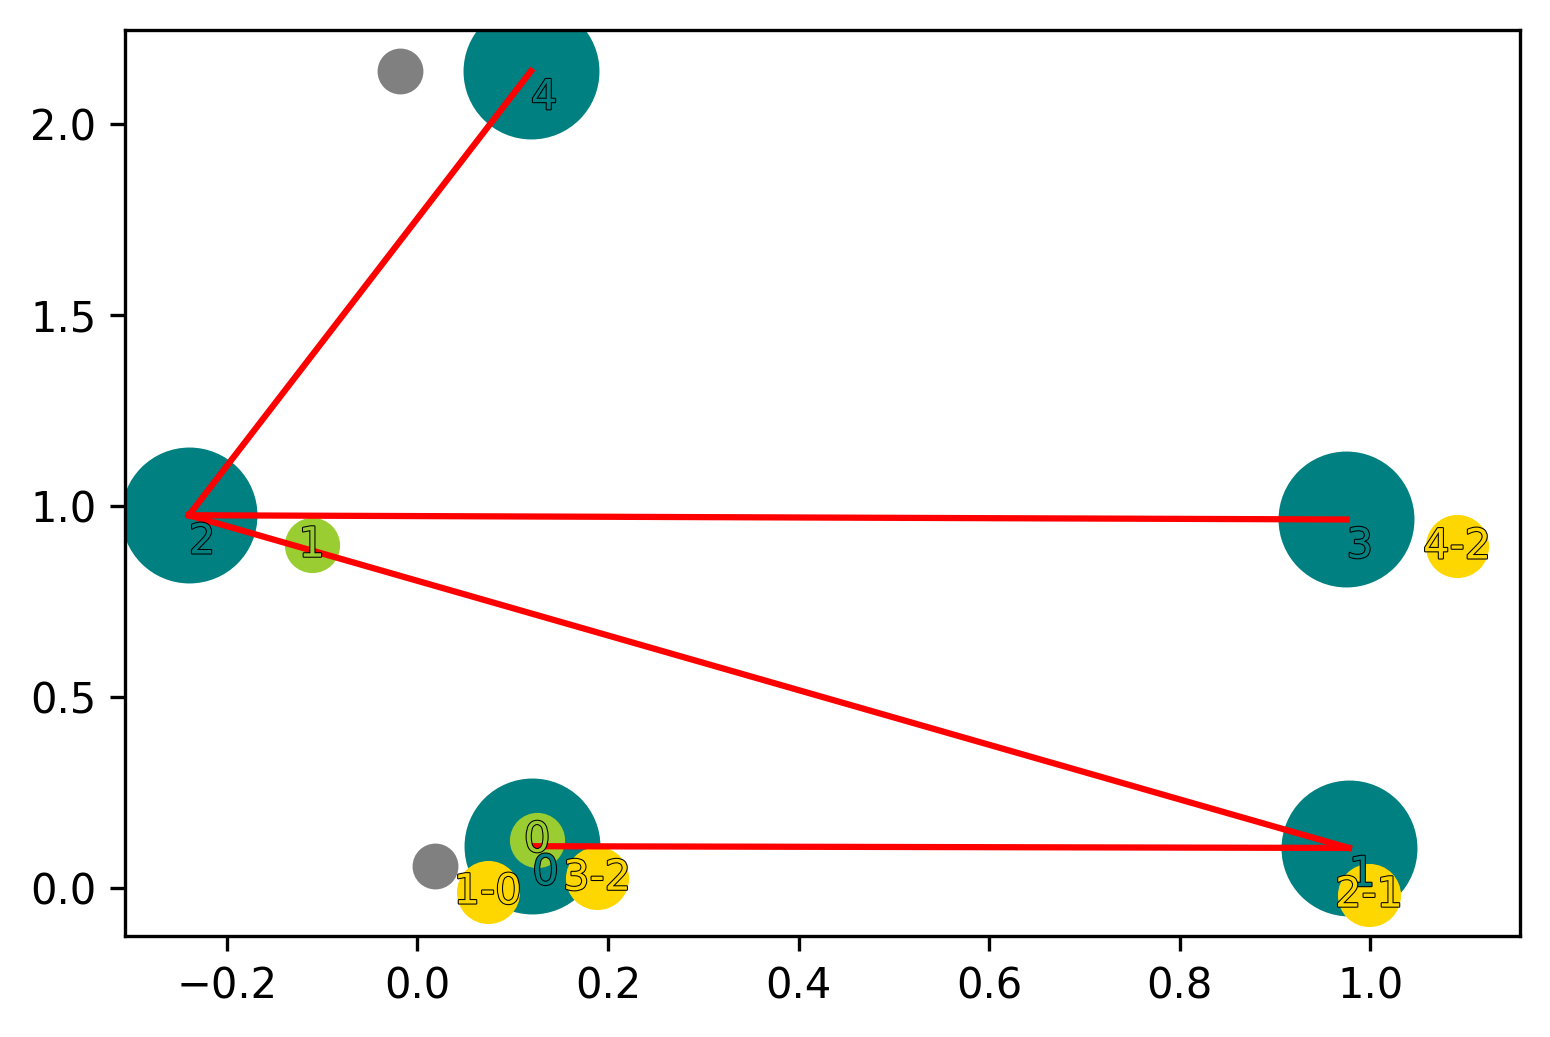

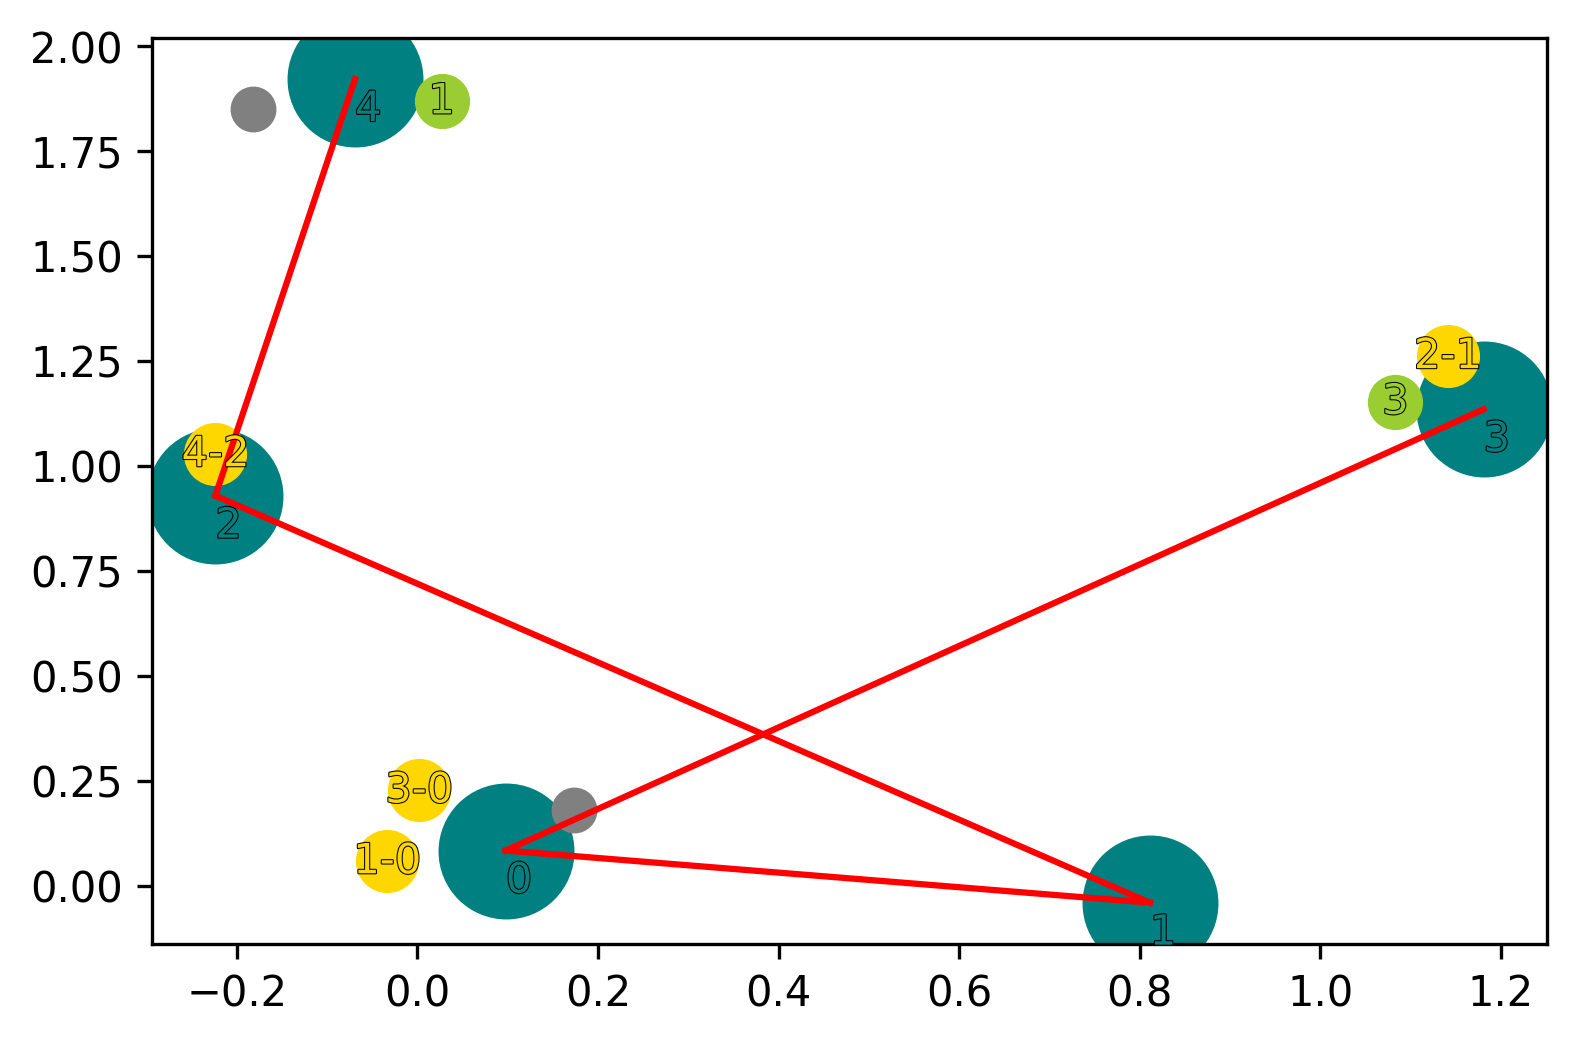

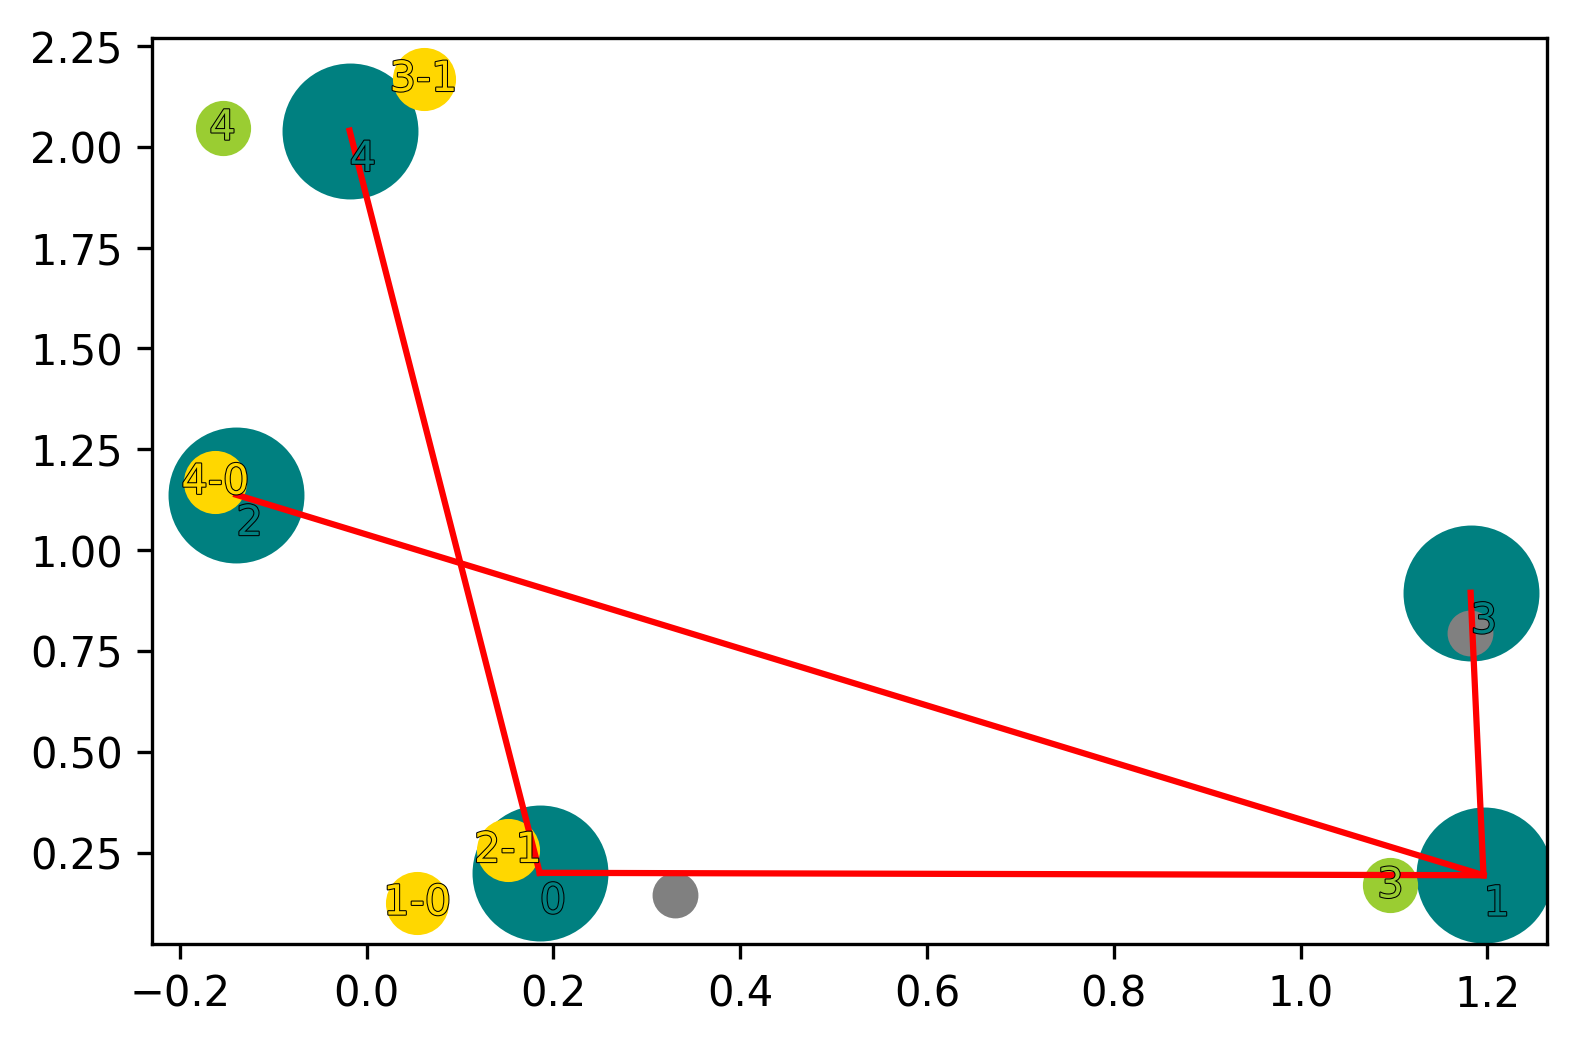

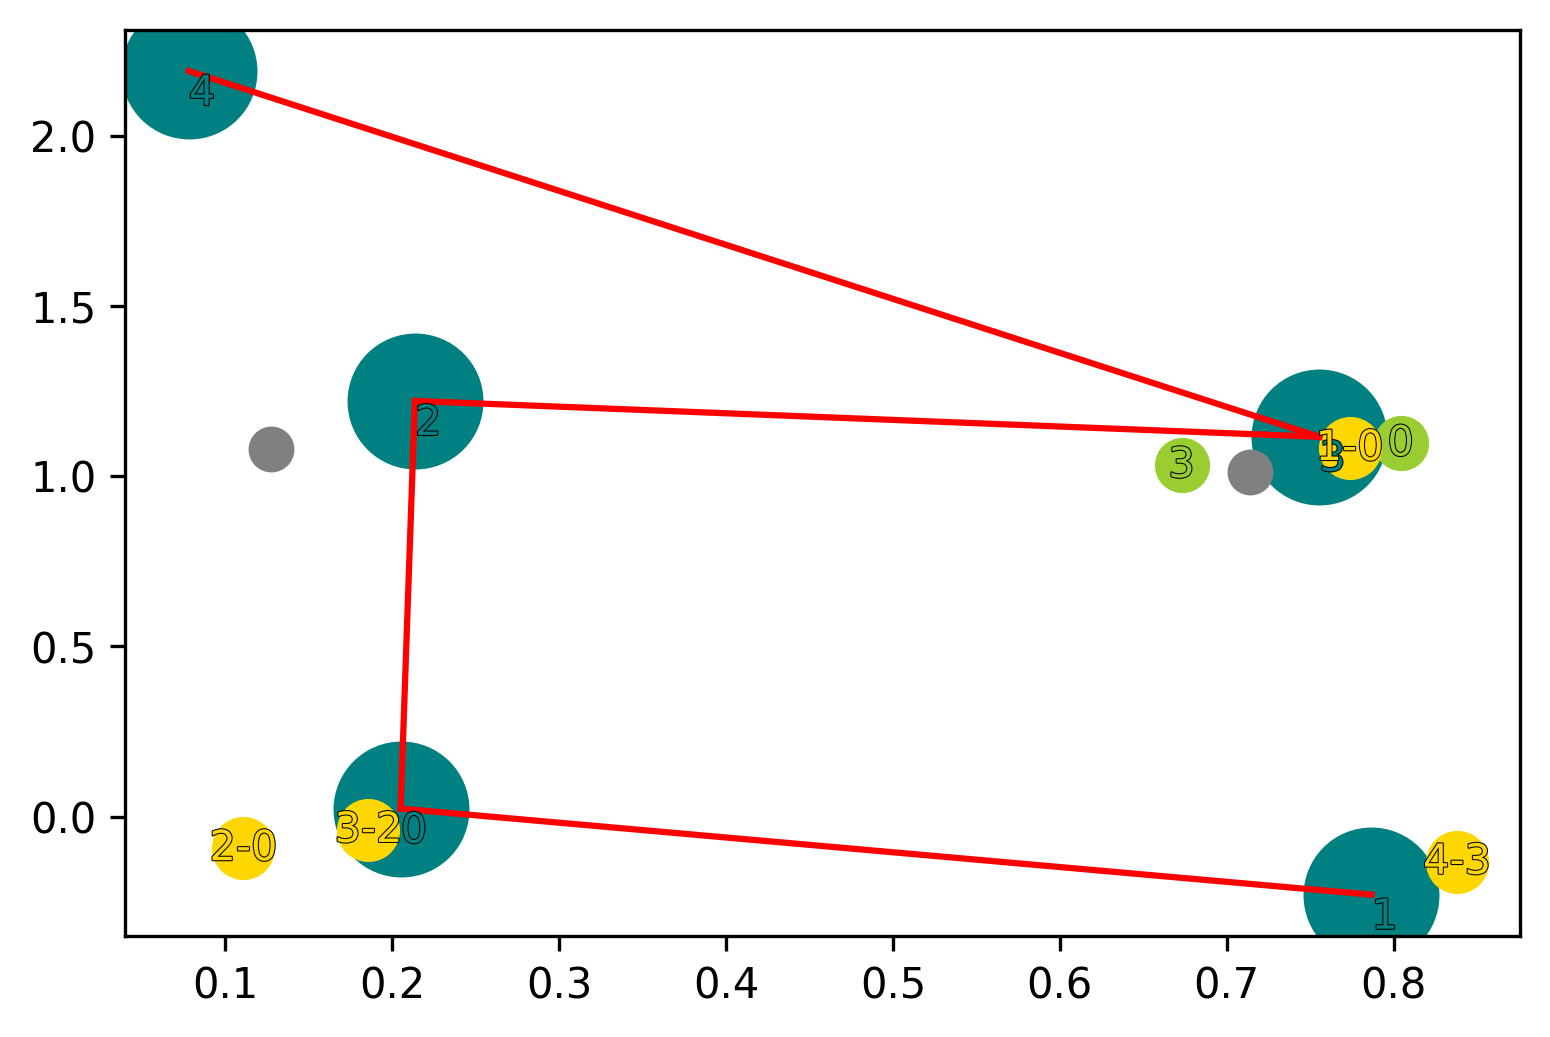

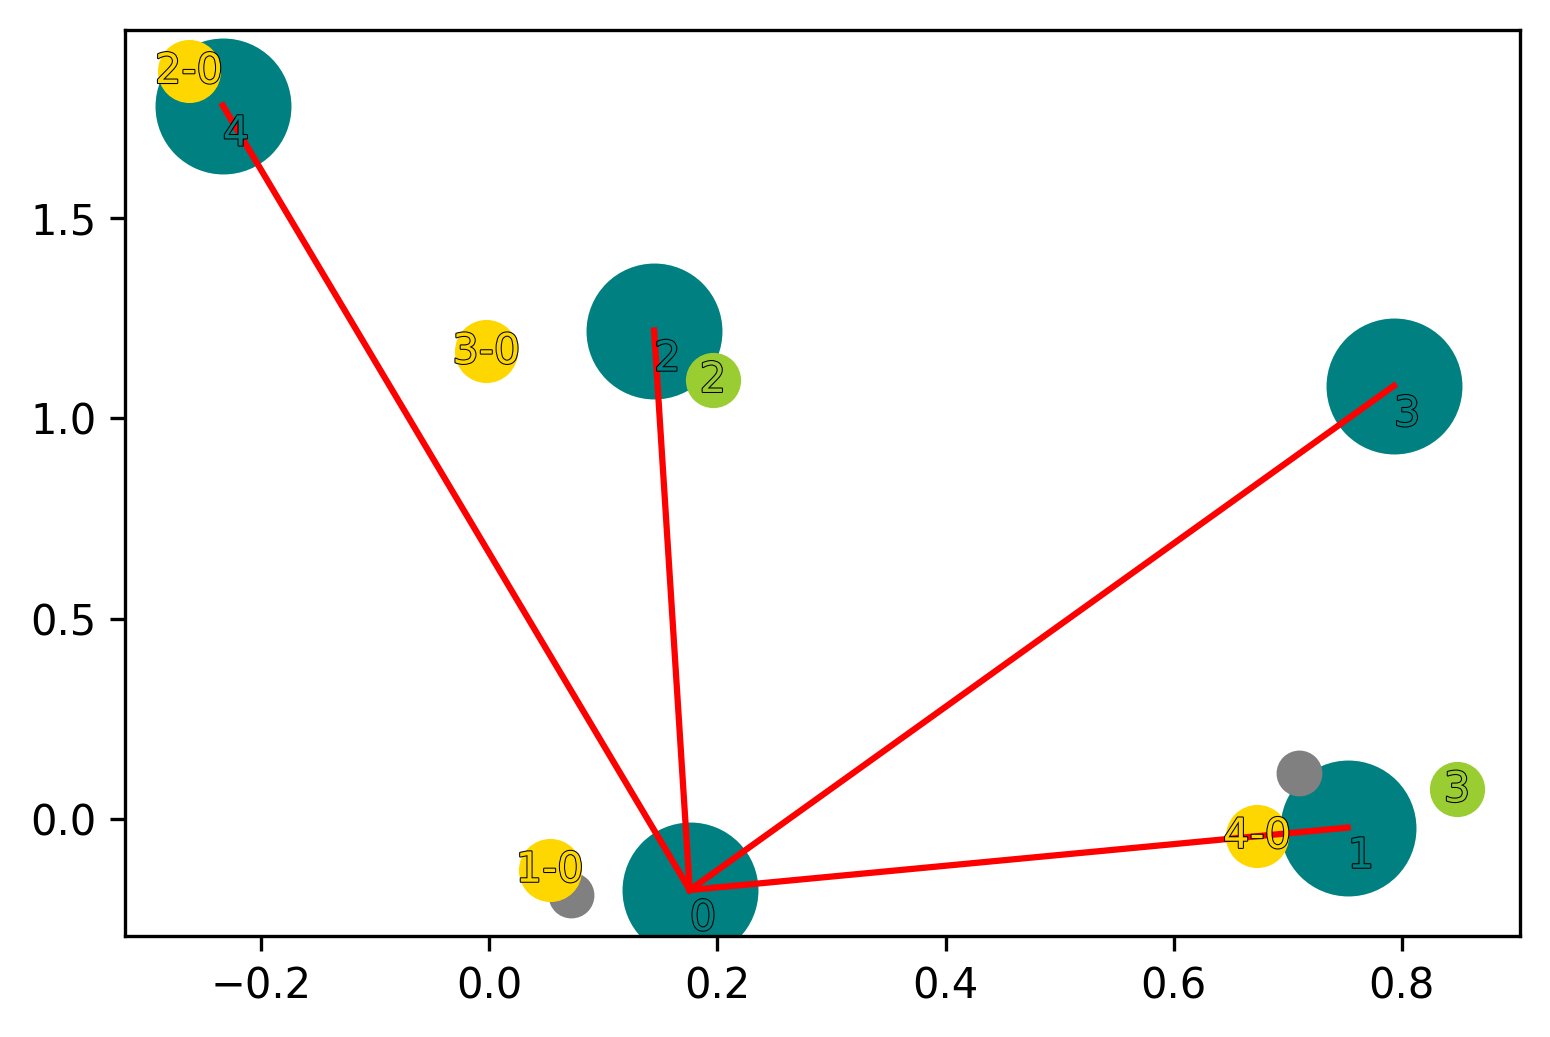

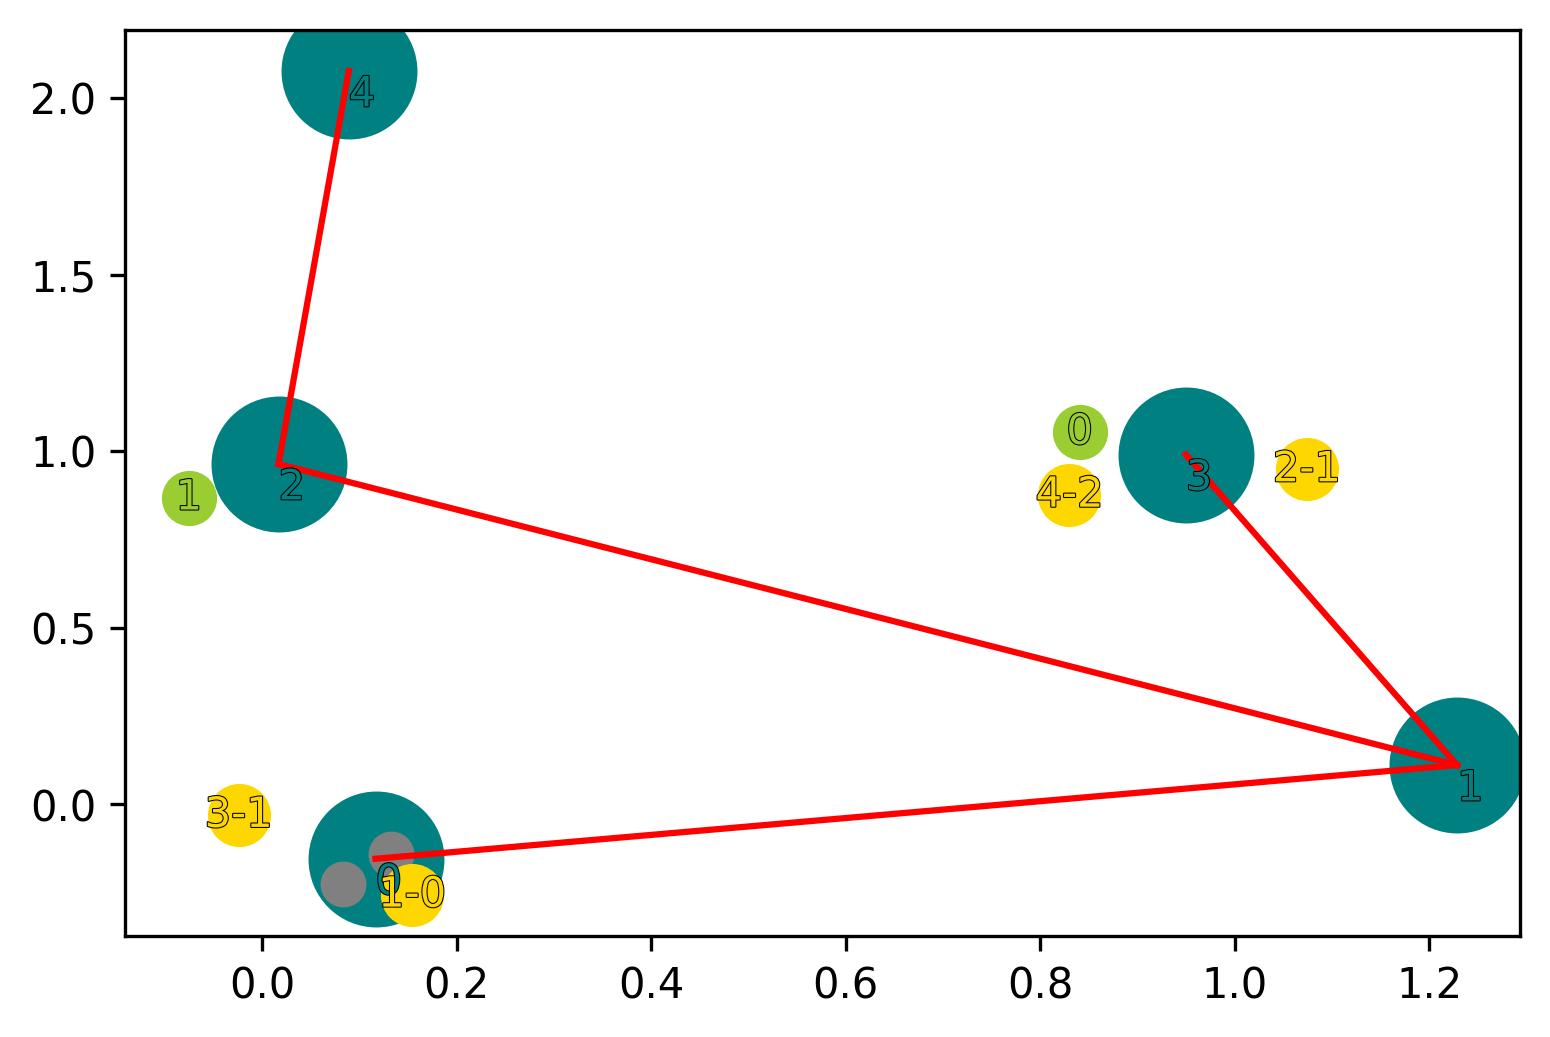

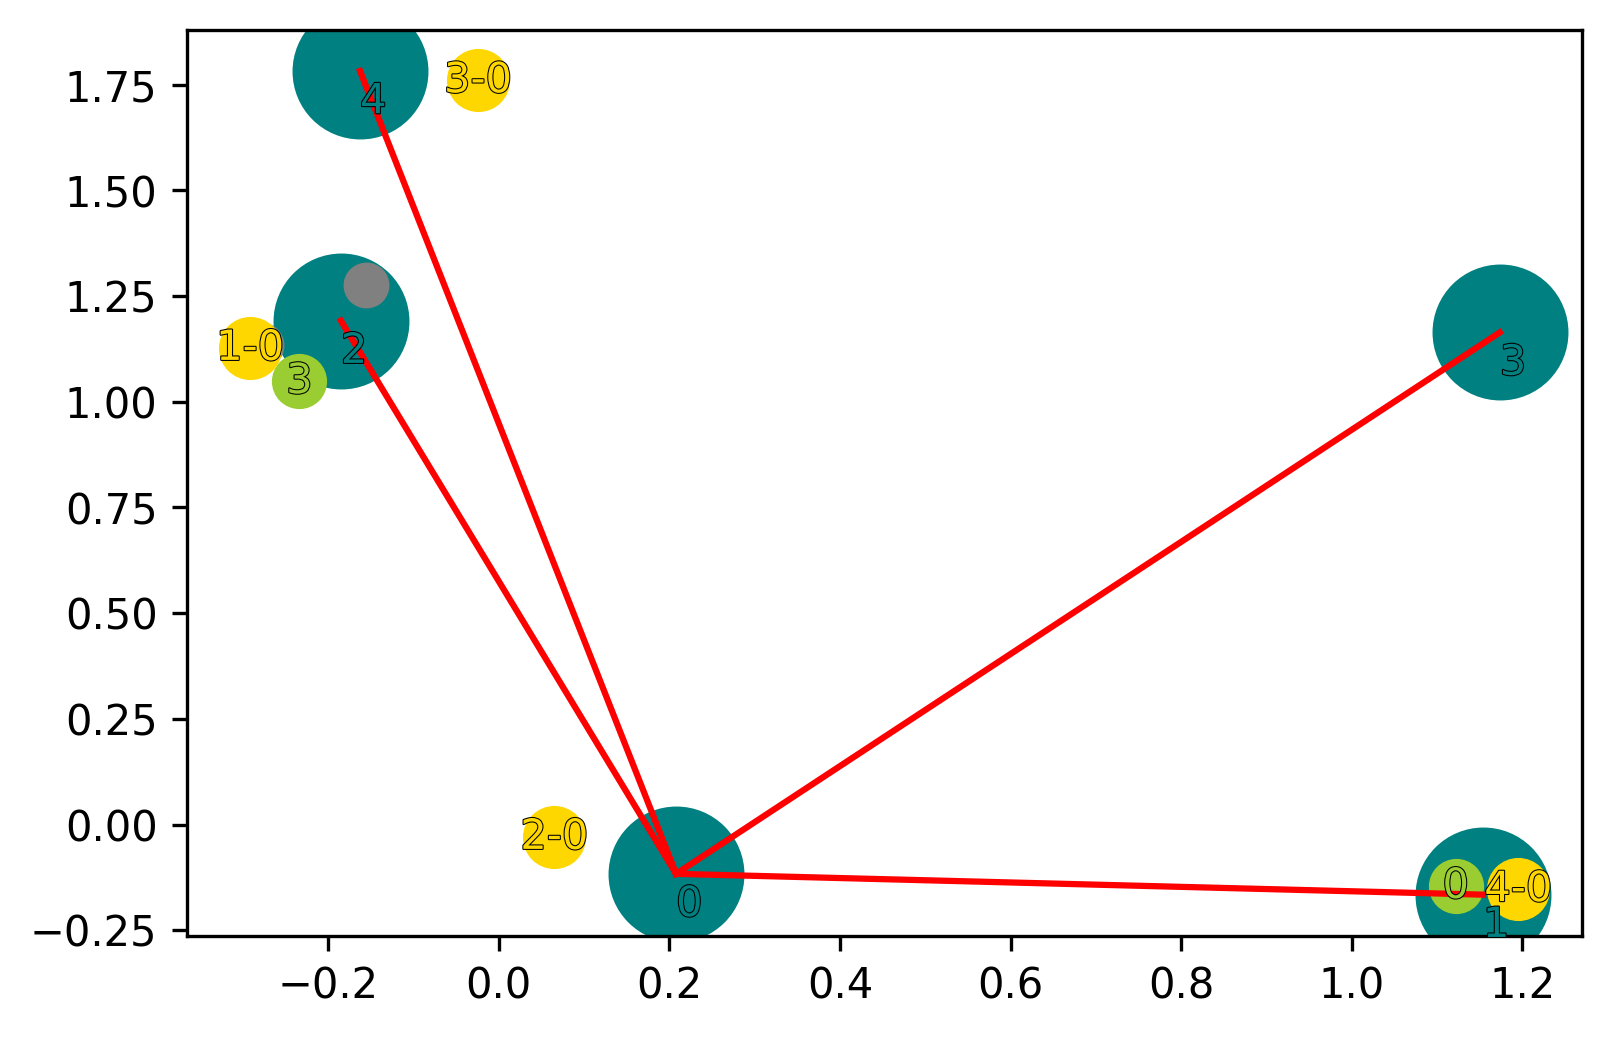

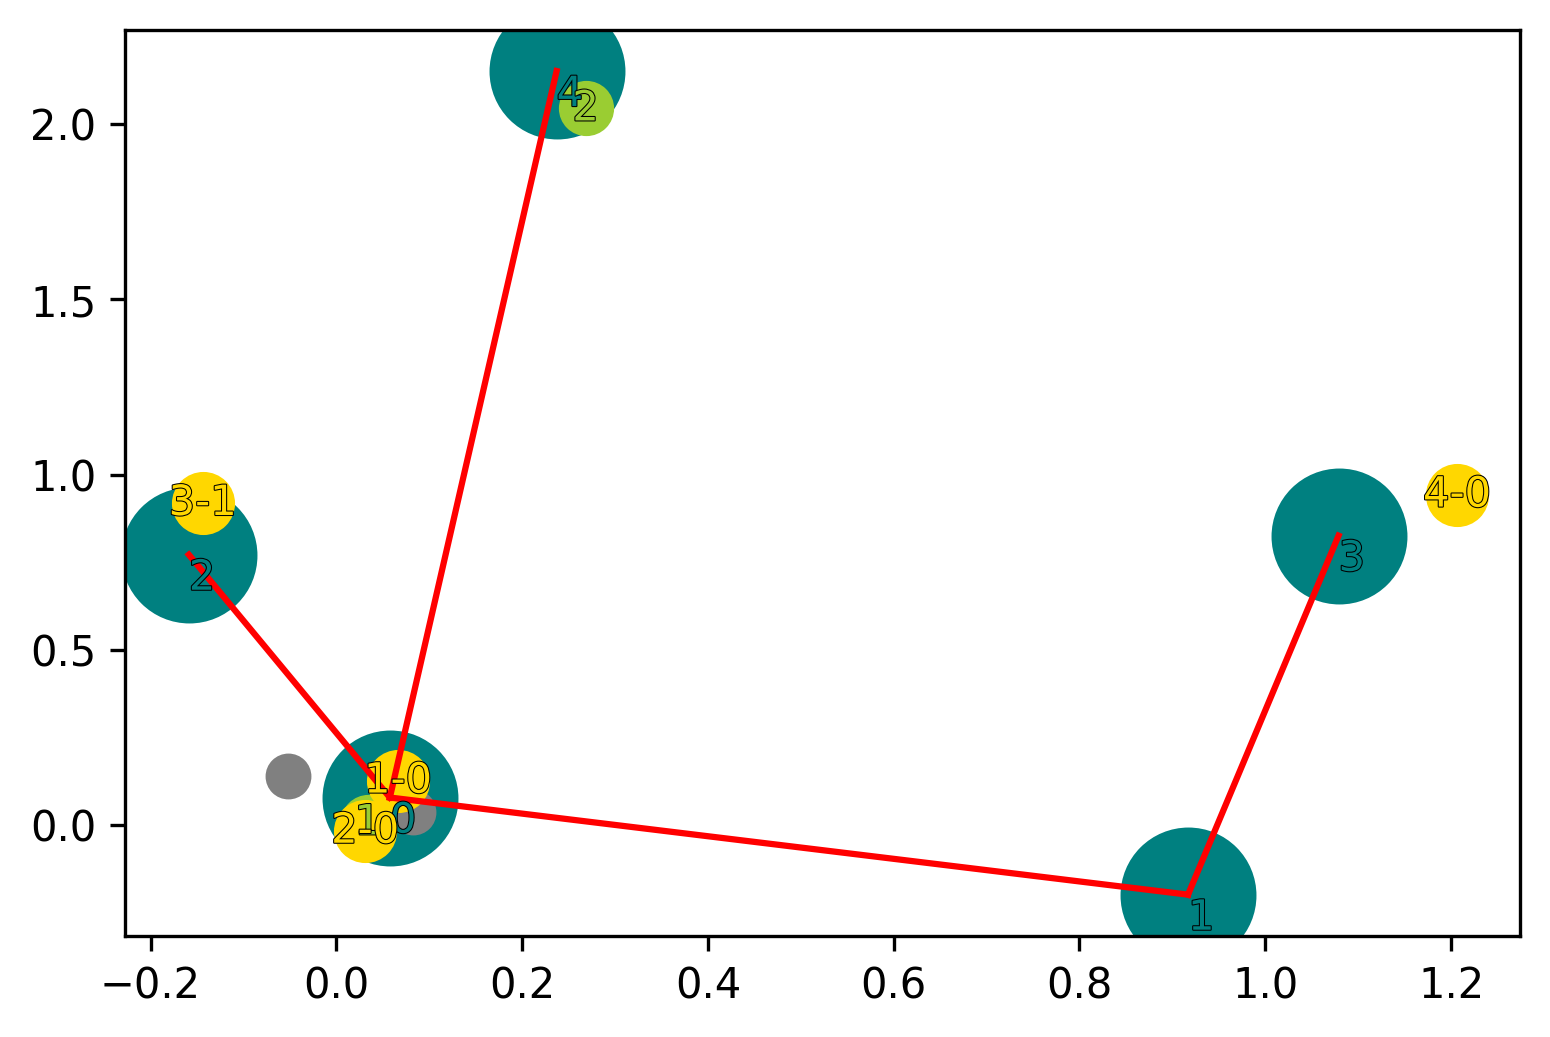

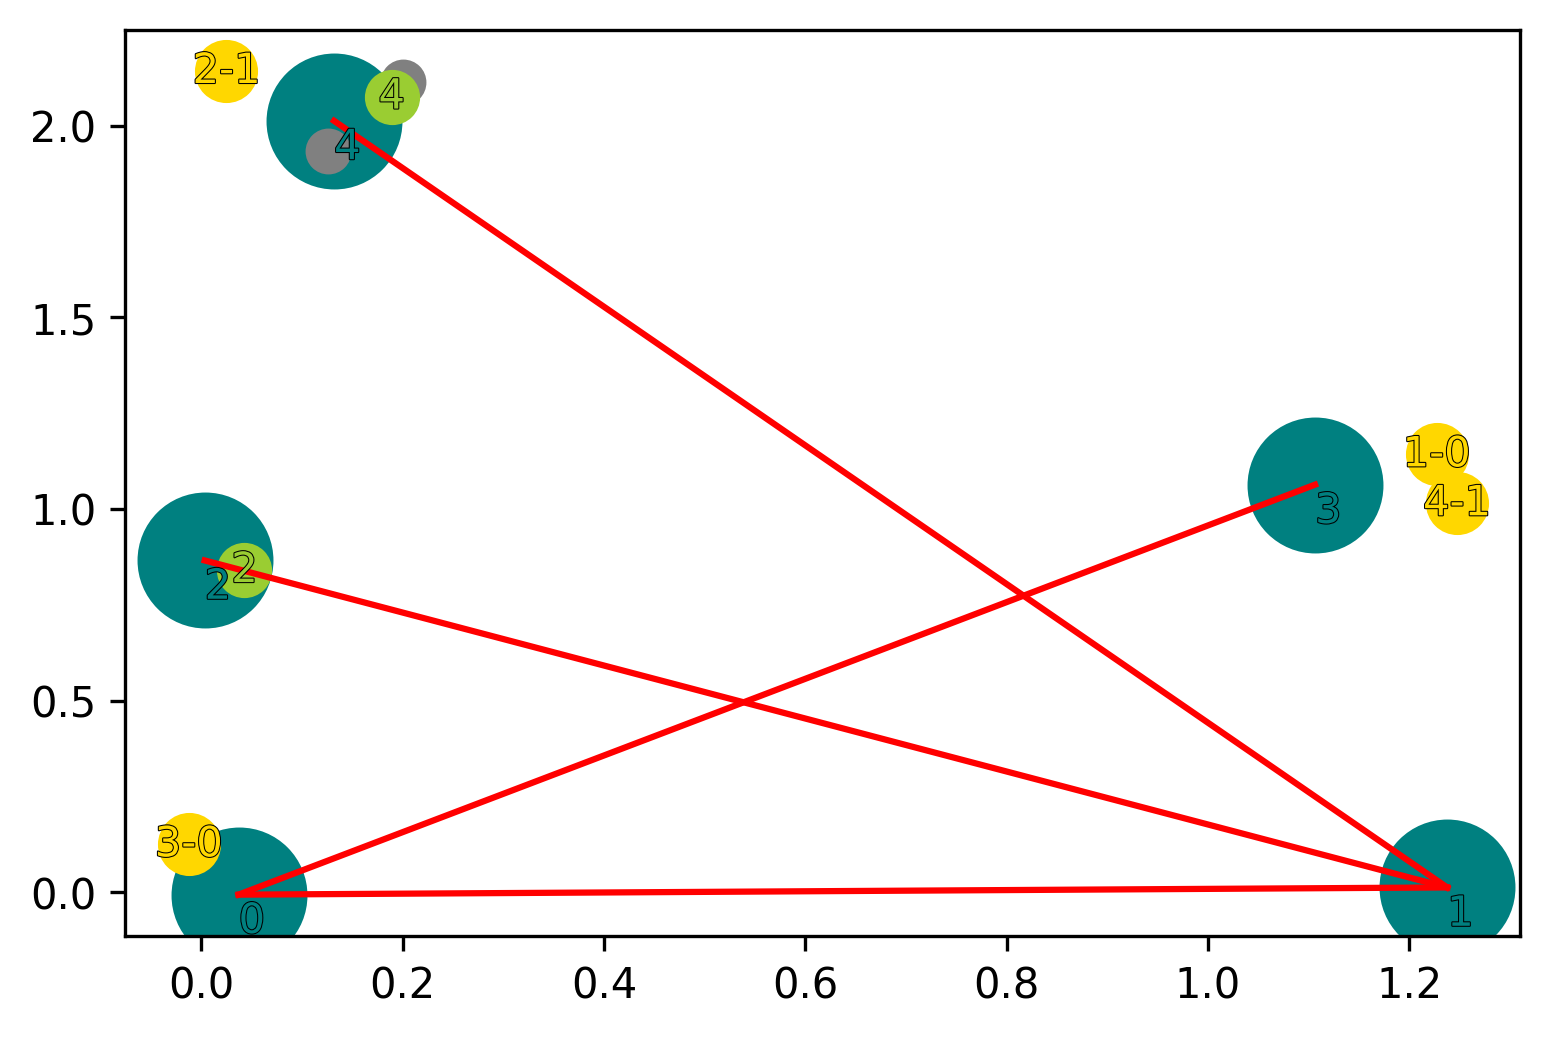

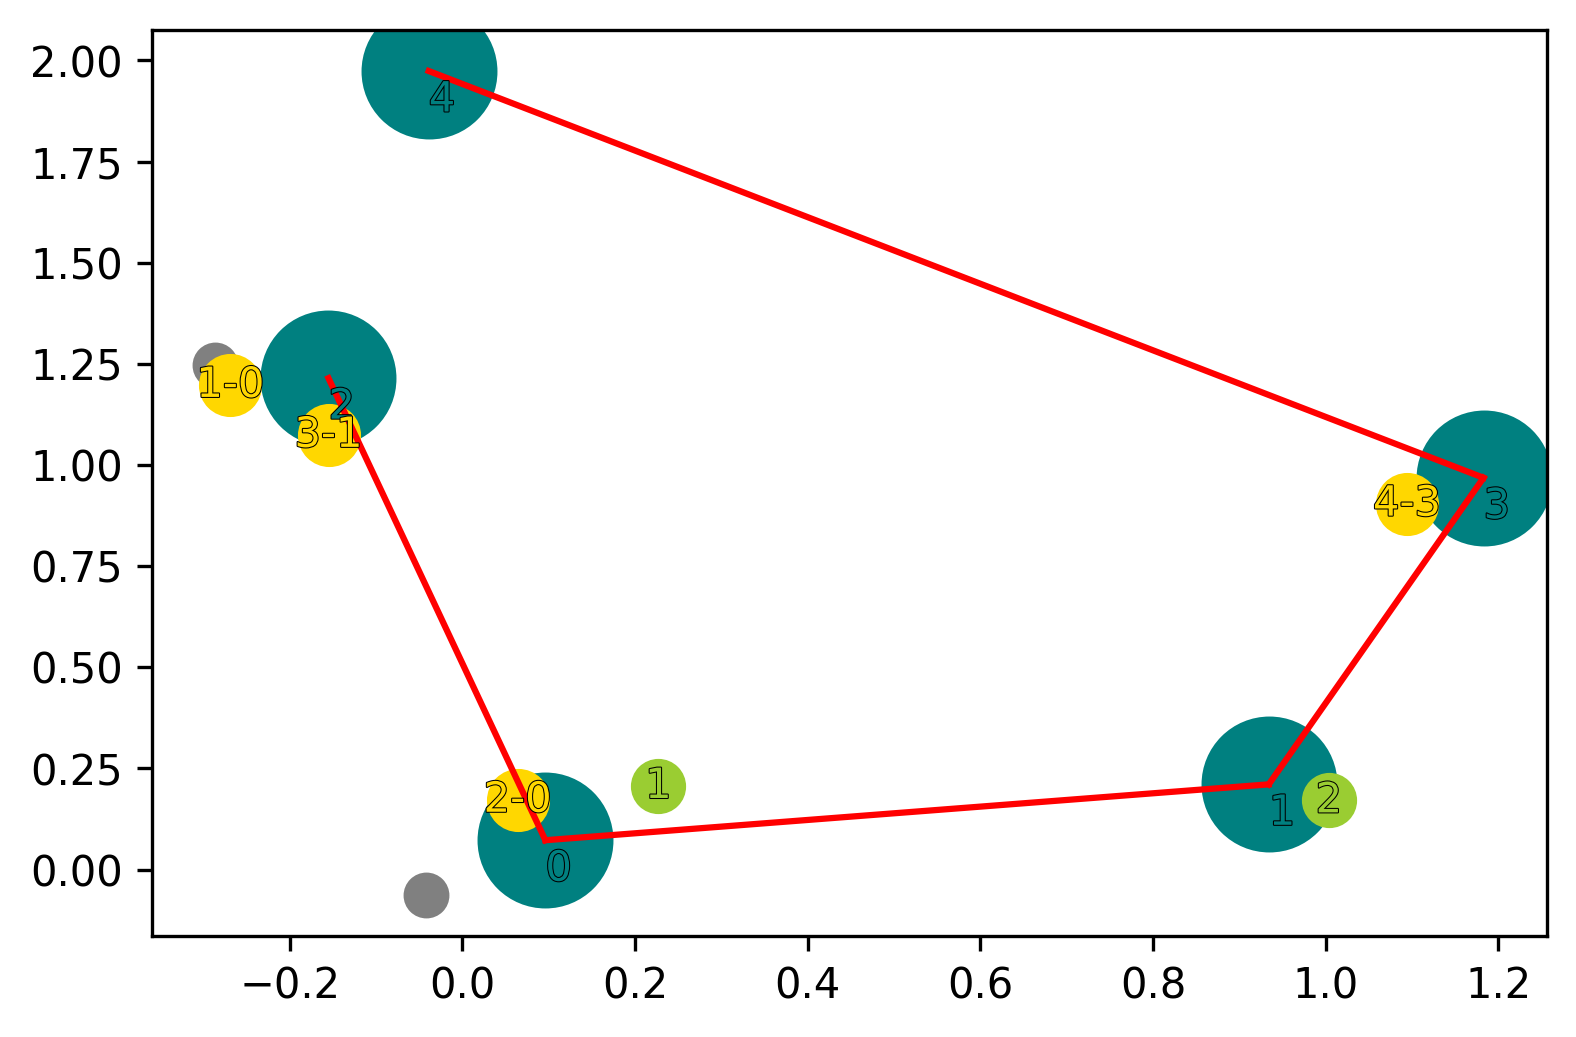

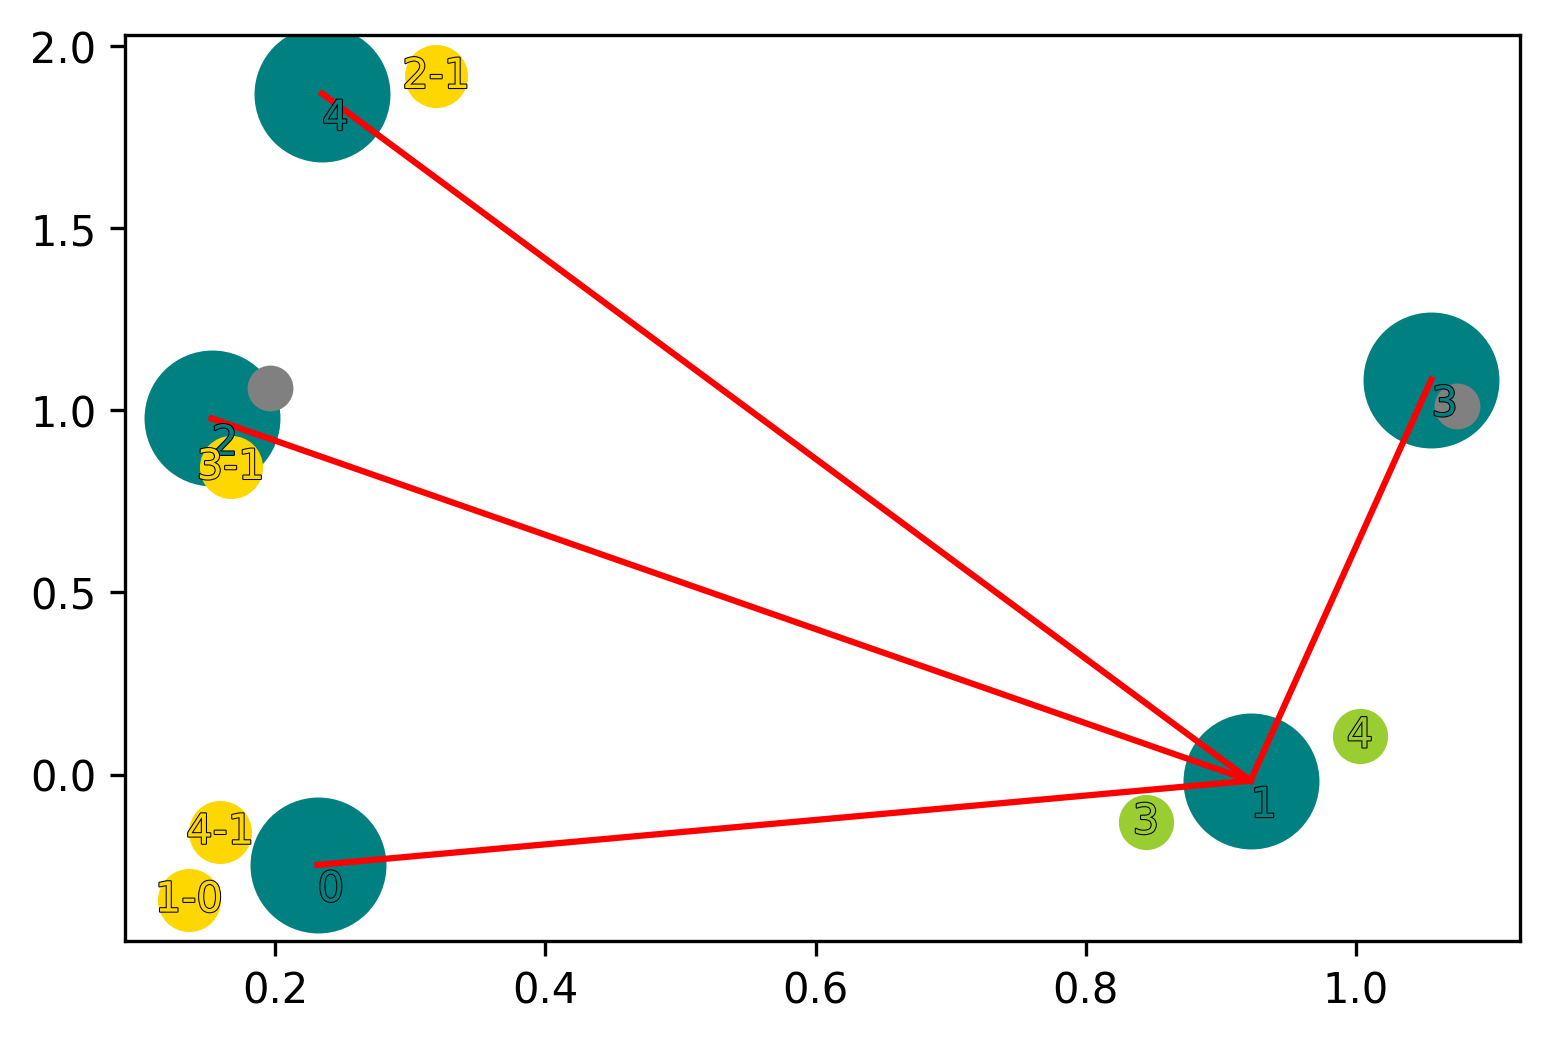

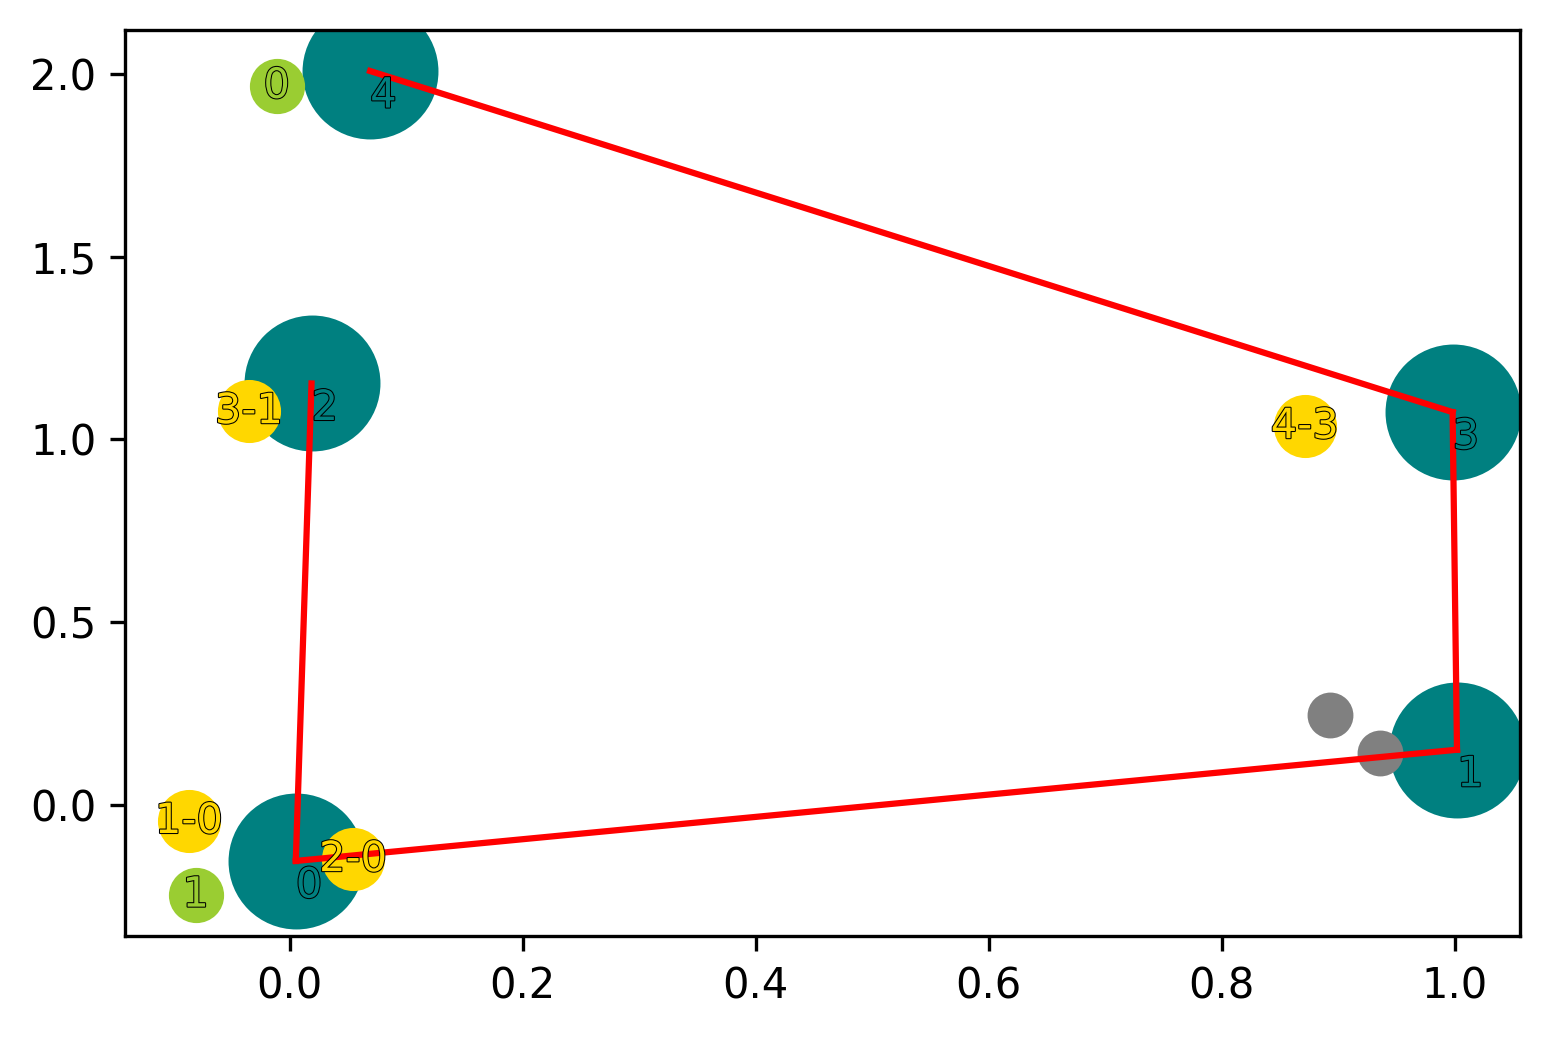

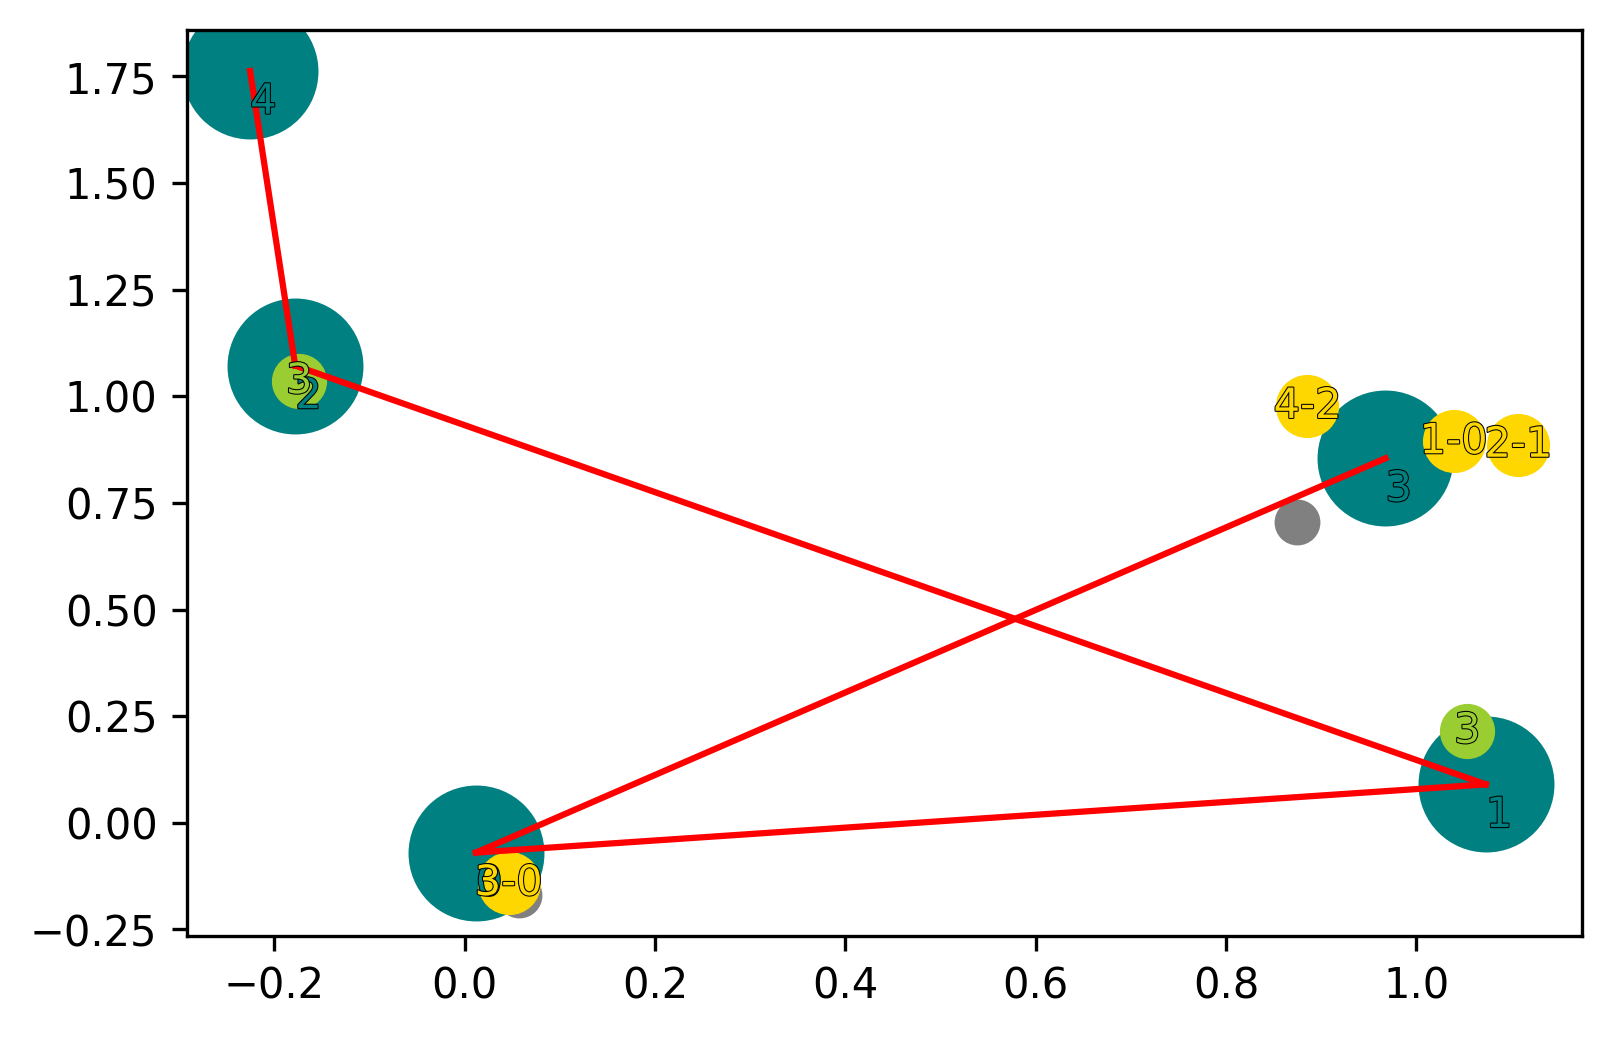

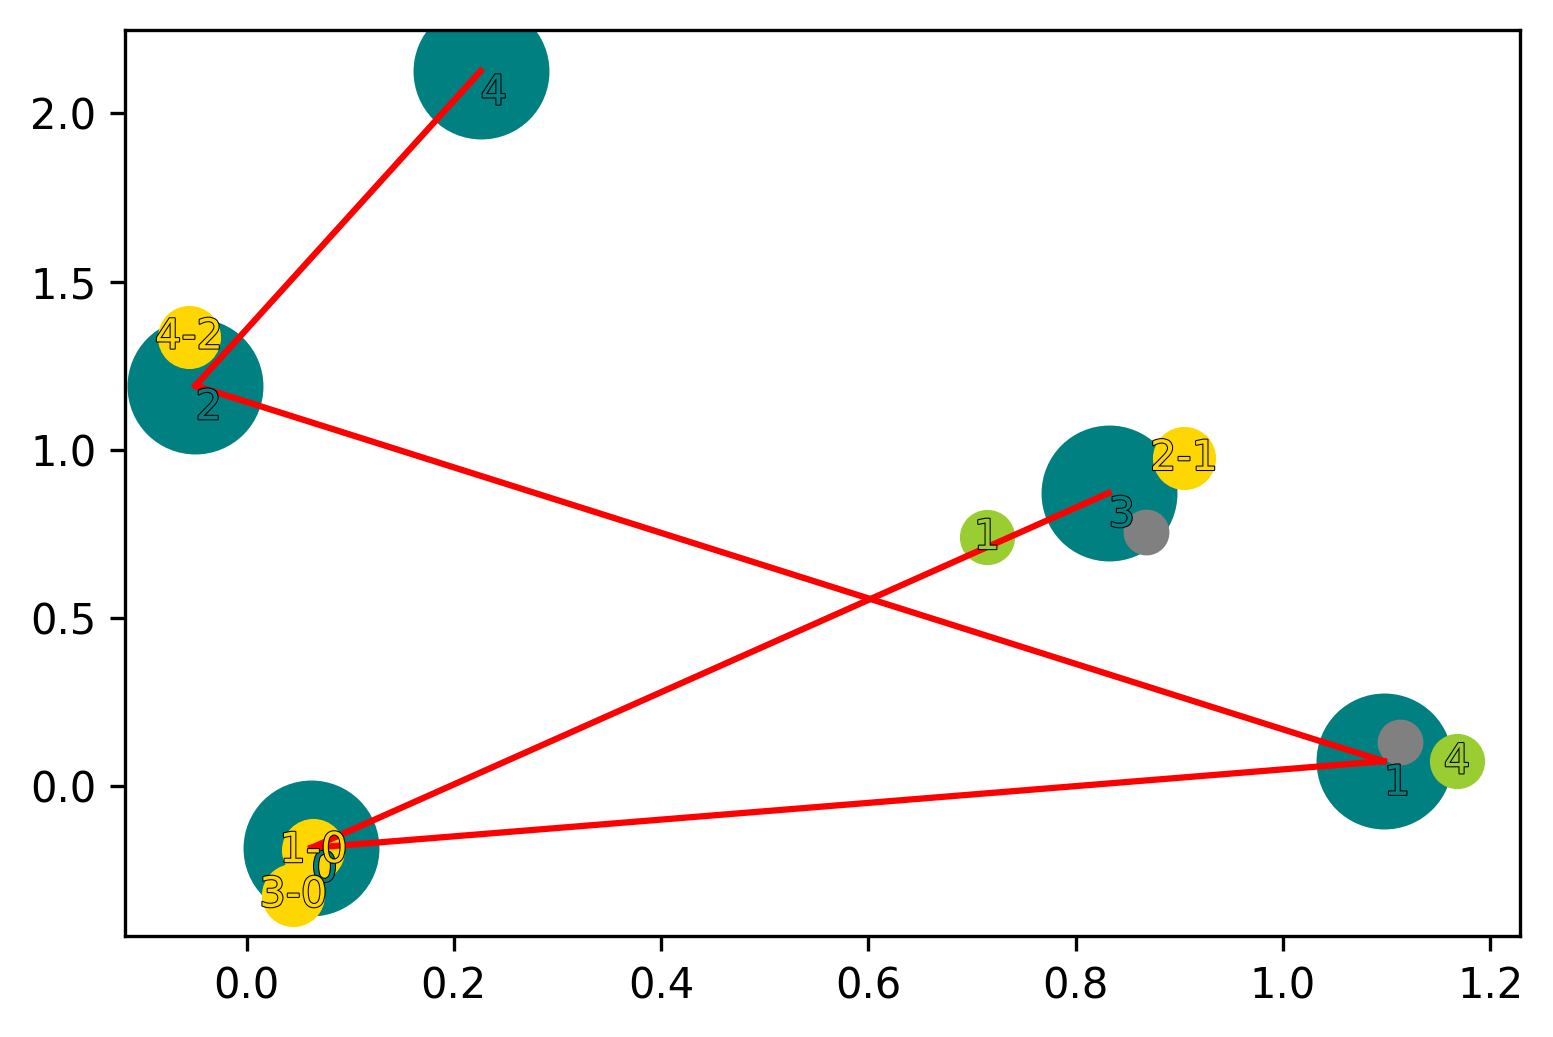

In [96]:
test = [generate(robot_capacity=25,
                 rooms_count=5,
                 additional_doors_count=0,
                 locked_doors_count=5,
                 goal_items_count=2,
                 useless_items_count=2,
                 max_item_weight=12,
                 visualise=True,
                 save=False) for x in range(20)]

# Just load weights for heuristic_optimized

In [7]:
w = loadtxt('weights.txt', delimiter=',')

# Or optimize weights

In [120]:
# prepare train set
seed(None)

files = glob.glob('levels/train*.png')
for f in files:
    os.remove(f)
    
train = [generate(robot_capacity=25,
                 rooms_count=6,
                 additional_doors_count=3,
                 locked_doors_count=6,
                 goal_items_count=5,
                 useless_items_count=10,
                 max_item_weight=12,
                 visualise=False,
                 save=True,
                 file_name=f'train/train_{x}.png') for x in range(100)]

In [ ]:
current_best = None
def test_heuristic(x, *args):
    mode = 'BF'
    randomise = False
    costf = None
    
    global w
    w = x
    result = test_algorithm(train,
                  mode,
                  max_nodes=10000,
                  loop_check=True,
                  randomise=randomise,
                  cost=costf,
                  heuristic=heuristic_optimized)
    
    try:
        float(result['solution_efficiency'])
    except:
        print('result:', 10**10)
        return 10**10
    global current_best
    score = result['time'] * result['memory'] * result['solution_efficiency']**2 / result['successful_runs']
    if current_best is None or score < current_best:
        current_best = score
        savetxt('weights.txt', np.array([x]), delimiter=',')
        
        print('weights:', x)
        print('test outcome:', result)
        print('result:', score)
    
    return score

minimize(test_heuristic, loadtxt('weights.txt', delimiter=','), method='Nelder-Mead')

# Testing

In [ ]:
full_test(easy, 200000, modes=['BF'], loop_checks=[True], randomises=[False], costfs=[None], heuristicfs=[heuristic_optimized])

In [117]:
full_test(medium, 200000, modes=['BF'], loop_checks=[True], randomises=[False], costfs=[None], heuristicfs=[heuristic_optimized])

.

time  memory  \
mode loop_check randomise cost_used heuristic_used                         
BF   True       False     No        heuristic_optimized  0.11695   493.6   

                                                         solution_efficiency  \
mode loop_check randomise cost_used heuristic_used                             
BF   True       False     No        heuristic_optimized                29.95   

                                                         successful_runs  \
mode loop_check randomise cost_used heuristic_used                         
BF   True       False     No        heuristic_optimized             20.0   

                                                         failed_runs  
mode loop_check randomise cost_used heuristic_used                    
BF   True       False     No        heuristic_optimized          0.0

In [118]:
full_test(hard, 200000, modes=['BF'], loop_checks=[True], randomises=[False], costfs=[None], heuristicfs=[heuristic_optimized])

.

time  \
mode loop_check randomise cost_used heuristic_used                  
BF   True       False     No        heuristic_optimized  4.963408   

                                                               memory  \
mode loop_check randomise cost_used heuristic_used                      
BF   True       False     No        heuristic_optimized  18047.263158   

                                                         solution_efficiency  \
mode loop_check randomise cost_used heuristic_used                             
BF   True       False     No        heuristic_optimized            54.368421   

                                                         successful_runs  \
mode loop_check randomise cost_used heuristic_used                         
BF   True       False     No        heuristic_optimized             18.0   

                                                         failed_runs  
mode loop_check randomise cost_used heuristic_used                    
BF   True       False     No        heuristic_optimized          1.0

In [8]:
full_test(insane, 200000, modes=['BF'], loop_checks=[True], randomises=[False], costfs=[None], heuristicfs=[heuristic_optimized])

.

time   memory  \
mode loop_check randomise cost_used heuristic_used                            
BF   True       False     No        heuristic_optimized  12.378844  28657.0   

                                                         solution_efficiency  \
mode loop_check randomise cost_used heuristic_used                             
BF   True       False     No        heuristic_optimized            49.785714   

                                                         successful_runs  \
mode loop_check randomise cost_used heuristic_used                         
BF   True       False     No        heuristic_optimized             13.0   

                                                         failed_runs  
mode loop_check randomise cost_used heuristic_used                    
BF   True       False     No        heuristic_optimized          1.0